In [2]:
%load_ext autoreload

%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import torch

sys.path.append('..')

from torch import nn
from Utils.NeuralNetworks import SigmoidNeuralNetwork
from Utils.utils import load_data, run_multiple_nn, run_multiple_forest, run_multiple_logistics
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define Paramaters

In [3]:
base_seed = 42
base_feature_size = 9
baseline_accuracy = 0.95

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Neural Network

In [4]:
X_train, y_train, _, _, feature_size  = load_data(base_seed, base_feature_size, discreteize=True, expand=False)

### Performing grid search

In [5]:
net = NeuralNetClassifier(
    module=SigmoidNeuralNetwork,
    max_epochs=50,
    criterion=nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=0.01,
    batch_size=2048,
    module__input_size=feature_size,
    device=device,
    train_split=None
)

params = {
    'optimizer__lr': [0.1, 0.01, 0.001],
    'max_epochs': [50],
    'batch_size': [1024],
    'module__layer_size': [32, 64],
    'module__layer_no': [1],
    'optimizer__weight_decay': [1e-3, 1e-4],
}

gs = GridSearchCV(net, params, refit=False, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)
clf = gs.fit(X_train, y_train.astype(float))

Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [6]:
print("Best parameters found: ", gs.best_params_)
print("Best accuracy found: ", gs.best_score_)

Best parameters found:  {'batch_size': 1024, 'max_epochs': 50, 'module__layer_no': 1, 'module__layer_size': 32, 'optimizer__lr': 0.01, 'optimizer__weight_decay': 0.001}
Best accuracy found:  0.9584722222222222


### Assesing performance

In [ ]:
nn_results, unscaled_guarantee = run_multiple_nn(gs, base_feature_size=base_feature_size, device=device, no_runs=10)

Run 1 / 10 started
Run finished with test accuracy: 0.9558333333333333
Run 2 / 10 started
Run finished with test accuracy: 0.9611111111111111
Run 3 / 10 started
Run finished with test accuracy: 0.9552777777777778
Run 4 / 10 started
Run finished with test accuracy: 0.9547222222222222
Run 5 / 10 started
Run finished with test accuracy: 0.9575
Run 6 / 10 started
Run finished with test accuracy: 0.955
Run 7 / 10 started
Run finished with test accuracy: 0.9583333333333334
Run 8 / 10 started
Run finished with test accuracy: 0.9541666666666667
Run 9 / 10 started
Run finished with test accuracy: 0.955
Run 10 / 10 started
Run finished with test accuracy: 0.9533333333333334


In [8]:
print(nn_results.head())

os.makedirs('results', exist_ok=True)
nn_results.to_csv(f'results/nn_results_{base_feature_size}.csv')

   Seed  epoch  train_loss  train_accuracy  test_accuracy
0     0      0    0.693292        0.513889       0.955833
1     0      1    0.681515        0.622153       0.955833
2     0      2    0.604501        0.721875       0.955833
3     0      3    0.412488        0.846458       0.955833
4     0      4    0.276608        0.919792       0.955833


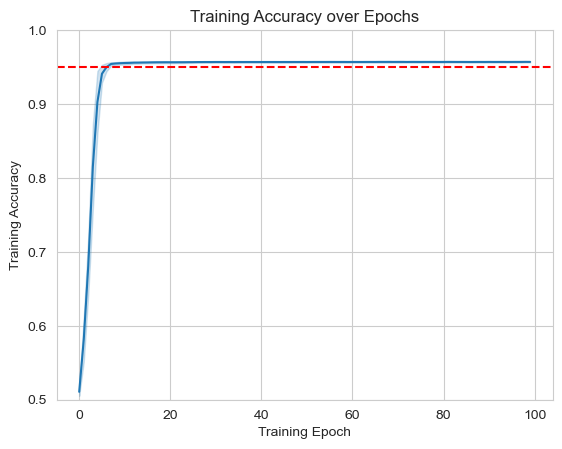

In [9]:
sns.set_style("whitegrid")
ax = sns.lineplot(data=nn_results, x='epoch', y='train_accuracy', errorbar='sd')
ax.set(xlabel='Training Epoch', ylabel='Training Accuracy', ylim=(0.5, 1.0), title='Training Accuracy over Epochs')
plt.axhline(y=baseline_accuracy, color='r', linestyle='--')
plt.show()

In [15]:
risk_tolerance = nn_results['test_accuracy'].mean() - baseline_accuracy
print(f'P(|E[r] - r_hat| > {risk_tolerance}) <= {unscaled_guarantee / risk_tolerance:.2f}')  

P(|E[r] - r_hat| > 0.006027777777777743) <= 0.04


# Random Forrests

In [16]:
X_train, y_train, _, _, feature_size  = load_data(base_seed, base_feature_size, discreteize=True, expand=True)

### Assessing Performance

In [19]:
forrest_results, unscaled_guarantee = run_multiple_forest(base_feature_size, no_runs=10)

Run 1 / 10 started
Run finished with test accuracy: 0.9588888888888889
Run 2 / 10 started
Run finished with test accuracy: 0.9633333333333334
Run 3 / 10 started
Run finished with test accuracy: 0.9586111111111111
Run 4 / 10 started
Run finished with test accuracy: 0.9555555555555556
Run 5 / 10 started
Run finished with test accuracy: 0.9577777777777777
Run 6 / 10 started
Run finished with test accuracy: 0.9558333333333333
Run 7 / 10 started
Run finished with test accuracy: 0.9611111111111111
Run 8 / 10 started
Run finished with test accuracy: 0.9563888888888888
Run 9 / 10 started
Run finished with test accuracy: 0.9566666666666667
Run 10 / 10 started
Run finished with test accuracy: 0.9558333333333333


In [20]:
print(forrest_results)

os.makedirs('results', exist_ok=True)
forrest_results.to_csv(f'results/rf_results_{base_feature_size}.csv')

   run  test_accuracy
0    0       0.958889
1    1       0.963333
2    2       0.958611
3    3       0.955556
4    4       0.957778
5    5       0.955833
6    6       0.961111
7    7       0.956389
8    8       0.956667
9    9       0.955833


In [21]:
print("Random Forest Accuracy:", forrest_results['test_accuracy'].mean())
print("Baseline to beat", baseline_accuracy)

Random Forest Accuracy: 0.958
Baseline to beat 0.95


In [22]:
risk_tolerance = forrest_results['test_accuracy'].mean() - baseline_accuracy
print(f'P(|E[r] - r_hat| > {risk_tolerance}) <= {unscaled_guarantee / risk_tolerance:.2f}')  

P(|E[r] - r_hat| > 0.008000000000000007) <= 0.03


# Logistic Regression

In [38]:
X_train, y_train, _, _, feature_size  = load_data(base_seed, base_feature_size, discreteize=True, expand=True)

### Performing Grid Search

In [39]:
params = {
    'alpha': [0.1, 0.15, 0.2],
    'max_iter': [1500],
    'tol': [1e-3],
    'learning_rate': ['optimal', 'constant'],
    'eta0': [0.01, 0.001],
}

logreg = SGDClassifier(loss='log_loss', n_jobs=-1)

gs = GridSearchCV(logreg, params, refit=False, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)
clf = gs.fit(X_train, y_train.astype(float))

Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [40]:
print("Best parameters found: ", gs.best_params_)
print("Best accuracy found: ", gs.best_score_)

Best parameters found:  {'alpha': 0.1, 'eta0': 0.01, 'learning_rate': 'optimal', 'max_iter': 1500, 'tol': 0.001}
Best accuracy found:  0.9584722222222222


### Assessing Performance

In [42]:
logreg_results = run_multiple_logistics(gs, base_feature_size, no_runs=10)

Run 1 / 10 started
Run finished with test accuracy: 0.9588888888888889
Run 2 / 10 started
Run finished with test accuracy: 0.9633333333333334
Run 3 / 10 started
Run finished with test accuracy: 0.9586111111111111
Run 4 / 10 started
Run finished with test accuracy: 0.9555555555555556
Run 5 / 10 started
Run finished with test accuracy: 0.9577777777777777
Run 6 / 10 started
Run finished with test accuracy: 0.9558333333333333
Run 7 / 10 started
Run finished with test accuracy: 0.9611111111111111
Run 8 / 10 started
Run finished with test accuracy: 0.9563888888888888
Run 9 / 10 started
Run finished with test accuracy: 0.9566666666666667
Run 10 / 10 started
Run finished with test accuracy: 0.9558333333333333


In [45]:
print(logreg_results)

os.makedirs('results', exist_ok=True)
logreg_results.to_csv(f'results/log_results_{base_feature_size}.csv')

   run  test_accuracy
0    0       0.958889
1    1       0.963333
2    2       0.958611
3    3       0.955556
4    4       0.957778
5    5       0.955833
6    6       0.961111
7    7       0.956389
8    8       0.956667
9    9       0.955833


In [44]:
print("Logistic Regression Accuracy:", logreg_results['test_accuracy'].mean())
print("Baseline to beat", baseline_accuracy)

Logistic Regression Accuracy: 0.958
Baseline to beat 0.95
